![image.png](https://user.oc-static.com/upload/2019/10/22/15717382019055_Capture%20d%E2%80%99e%CC%81cran%202019-10-22%20a%CC%80%2011.50.29.png)

**Air Paradis** est une compagnie aérienne qui souhaite utiliser l'IA (*Intelligence Artificielle*) pour **détecter les Bad Buzz associés à sa marque** dans les tweets publics en ligne.

**En tant qu'ingénieur AI pour Marketing Intelligence Consulting**, nous allons nous plonger dans les techniques de **NLP** (*Natural Language Processing*) pour servir l'objectif d'Air Paradis.

En effet, le NLP permet à une machine de **comprendre et de traiter le langage humain**. Il nous aidera à résoudre cet **objectif de classification de texte** et à **détecter le sentiment** (positif ou négatif) de ces tweets.

# Import des librairies et chargement des données

In [1]:
import dateutil, datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import contractions

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

import pycld2 as cld2

import spacy
import en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser'])

from collections import Counter

Le projet ne fournit pas de donnée nous allons donc en récupéré via ce lien https://www.kaggle.com/datasets/kazanova/sentiment140.

- convertir la chaîne PDT (fuseau horaire US/Pacifique).

Voici les différentes colonnes de notre ressource :

- **target**: la polarité du tweet (0 = négatif, 2 = neutre, 4 = positif. Mais nous n'avons pas de sentiment = 2 dans notre jeu de données)

- **ids**: l'identifiant du tweet

- **date**: la date du tweet

- **flag**: la requête. S'il n'y a pas de requête, cette valeur est NO_QUERY.

- **user**: l'utilisateur qui a tweeté

- **text**: le texte du tweet

In [2]:
df = pd.read_csv(
    'data/training.1600000.processed.noemoticon.csv',
    encoding='ISO-8859-1',
    # Nous précison le nom de chaque colonne car elles n'ont
    # pas d'en tête'
    names=['sentiment', 'id', 'date', 'flag', 'user', 'tweet'])

# Supprime la colonne flag qui, nous pensons, ne sera pas utile
del df["flag"]

In [4]:
df.head(2)

,sentiment,id,date,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


# Selection des données

Les tweets négatifs ont pour valeur "0" et "4" pour les tweets positifs.

Remplaçons ces valeurs pour les rendre un peu plus claires :

- 0 pour les tweets négatifs 

- 1 pour les tweets positifs.

In [5]:
df['sentiment'] = df['sentiment'].replace([0, 4], [0, 1])

df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

La target est plutôt equilibrée pour le moment.

# Premier nettoyage

Nous savons que les tweets ont été envoyés du 6 mai 2009 au 25 juin 2009. Nous pouvons supprimer la colonne date qui ne sera surement pas très utile.

In [6]:
del df['date']

Passons aux valeurs manquantes.

In [7]:
df.isnull().values.any()

False

Nous n'avons aucune valeur manquante pour le moment. Passons aux doublons.

In [8]:
df[df.duplicated(subset=['user', 'tweet'])].sort_values("user")

,sentiment,id,user,tweet
999959,1,1879941003,007peter,"@NaniWaialeale No, not Keith Olbermann, he ann..."
995446,1,1835719548,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
889033,1,1687496734,007wisdom,&quot;All that we are is the result of what we...
984036,1,1834348688,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
953751,1,1824711167,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
...,...,...,...,...
1579667,1,2189971294,zibbet,Learn how to 'Effectively Promote Your Shop' u...
1185965,1,1982872880,zoetunstall,@tommcfly Hey Tom whereabouts in Uganda did y...
942791,1,1794782830,zoezf,@enzopilarta kakaasar kasi eh! puro cliffhange...
1591551,1,2191582417,zombieite,packing :-| :-/ :-?


Seuls les doublons sur les tweets sont vraiment importants. Mais nous devons supprimer les doublons de tweet lorsqu'ils appartiennent au même utilisateur, pour ne pas supprimer deux mêmes tweets que deux personnes auraient postés.

In [9]:
df.drop_duplicates(subset=['user', 'tweet'], inplace=True)
df[df.duplicated(subset=['user', 'tweet'])].sort_values("user")

,sentiment,id,user,tweet


# Preprocessing

Dans cette section, nous allons créer une série de fonctions de prétraitement, pour nettoyer les tweets et les rendre plus lisibles.

Nous allons effectuer les étapes suivantes :

- Normaliser le texte en minuscules ;
- Corriger certaines fautes d'orthographe que nous avons détectées ;
- Supprimer (ou remplacer) toutes les mentions d'utilisateurs, urls, hyperliens, emails et hashtags ;
- Supprimer (ou remplacer) certains caractères spécifiques ;
- Développer toutes les contractions anglaises pour conserver le sens et notamment le mot " not " qui pourrait être essentiel pour détecter un sentiment négatif ;
- Supprimer les chiffres et les caractères spéciaux ;
- Supprimer les ponctuations ;
- Supprimer les espaces blancs.
- La lemmatisation 

Concernant les stopswords.

Nous pouvons penser que comme les stopswords (ex.: the, a, of, ...) sont très couramment utilisés en anglais et que par conséquent, ils n'ont aucune signification contextuelle et doivent être supprimés. 

Mais pour l'analyse des sentiments, il est préférable de conserver tous les mots.

Un exemple pourrait être la phrase suivante : “I told you that she was not happy” ("Je vous ai dit qu'elle n'était pas heureuse"). Si nous supprimons les stopwords, cela donnerait [‘told’, ‘happy’] (['dit', 'heureuse']) qui sera détecté comme un sentiment positif.

Pour plus d'infos : https://medium.com/@limavallantin/why-is-removing-stop-words-not-always-a-good-idea-c8d35bd77214

Nous allons séparer les tweets de bases et les tweets traités.

In [10]:
df['tweet_traite'] = df['tweet'].copy()

df.head()

,sentiment,id,user,tweet,tweet_traite
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


#### Preproccessing general (regex, lemmatisation...)

In [11]:
# Le tokenizer prend en compte les hashtag et les émojis dans la séparation
# des caractères
tknzr = TweetTokenizer()


def contraction(tweet):
    """
    Les contractions en anglais sont les "I'm" pour "I am", "It's" pour
    "It is". Nous allons donc remplacer les contractions pour avoir le 
    pronom et le verbe bien distinct
    """
    tweet = contractions.fix(tweet)
    return tweet


def traitement_tweet(tweet):
    """
    Cette fonction permet le traitement des textes de toutes la colonne
    sans boucle sur la dataframe.
    
    case=True/False --> sensibilité au majuscule et minuscule
    """
    # Convertis le tweet en minuscules
    tweet = tweet.str.lower()

    # Suppression des caractères échappés de Twitter (guillemets, esperluettes,
    # acronymes, émoticônes...)
    tweet = tweet.str.replace('&quot|&amp;|&gt;|&lt;', '')

    # Supprimer les URLs standards (commençant par http, https ou www)
    tweet = tweet.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)

    # Supprimez les autres hyperliens (se terminant par .com, .org ou .net).
    tweet = tweet.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)

    # Remplacer toutes les mentions @ par users et # par hashtags
    tweet = tweet.str.replace(r'@[\w]*', 'user', case=False)
    tweet = tweet.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hashtag')

    # Supprime les réactions qui ne sont pas dans le dictionnaire
    tweet = tweet.str.replace(
        'lol|oh |haha|blah|ahh|aww|wow|yeah|yay|hmm|wtf|grr', '')

    # Replace "-" et " ' " par un espace
    tweet = tweet.str.replace("-|'", ' ')

    # Supprime tous les caractères numériques et spéciaux
    tweet = tweet.str.replace(r'[^a-zA-Z\s]', ' ')

    # Supprime la ponctuation
    tweet = tweet.str.replace(r'[^\w\s]+', '')

    # Nous allons supprimer renommer les mots en abrégés.
    # Les espaces sont là pour éviter de modifier la lettre dans un mot
    # exemple : pour 'u : 'you' alors 'user' va devenir 'youser'
    dict_abrege = {
        'omg': 'god',
        'gosh': 'god',
        'its': 'it is',
        'idk': 'i do not know',
        'your welcome': 'you are welcome',
        'bday': 'birthday',
        ' ur ': ' your ',
        ' til ': ' until ',
        'shoulda': 'should',
        'fb': 'facebook',
        'thx': 'thanks',
        ' yur ': ' your ',
        ' u ': ' you '
    }

    # Corrige les mots en abrégé
    for key in dict_abrege.keys():
        tweet = tweet.str.replace(key, dict_abrege[key], case=True)

    return tweet

In [12]:
def lemmatisation(tweet):
    doc = nlp(tweet)
    tweet = " ".join([token.lemma_ for token in doc])

    return tweet


porter_stemmer = PorterStemmer()


def stemming(tweet):
    tokens = tweet.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


def supprime_lettre_seul(df, colonne):
    df[colonne] = df[colonne].str.replace(r'\b\w\b',
                                          '').str.replace(r'\s+', ' ')
    return df

In [13]:
%%time
df['tweet_traite'] = df['tweet_traite'].apply(contraction)
df['tweet_traite'] = traitement_tweet(df['tweet_traite'])

/tmp/ipykernel_539/3665271016.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace('&quot|&amp;|&gt;|&lt;', '')
/tmp/ipykernel_539/3665271016.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)
/tmp/ipykernel_539/3665271016.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)
/tmp/ipykernel_539/3665271016.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'@[\w]*', 'user', case=False)
/tmp/ipykernel_539/3665271016.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hashtag')
/tmp/

CPU times: user 50.9 s, sys: 552 ms, total: 51.4 s
Wall time: 51.4 s


In [14]:
%%time
df['tweet_stemm'] = list(df["tweet_traite"])
df['tweet_stemm'] = df['tweet_stemm'].apply(stemming)

CPU times: user 3min 23s, sys: 60.3 ms, total: 3min 23s
Wall time: 3min 23s


In [15]:
%%time
# # Lemmatise les tweets
df["tweet_lemm"] = df['tweet_traite'].apply(lambda x: lemmatisation(x))

CPU times: user 1h 51min 4s, sys: 1.31 s, total: 1h 51min 5s
Wall time: 1h 51min 5s


L'exécution de la précédente cellule étant très longue (1h10), nous allons exporter la dataframe sous csv et réduire le temps d'exécution du notebook pour le développement.

Le fichier csv aura donc l'étape de la lemmatisation que nous n'aurons plus besoin de faire.

In [16]:
df.to_csv("data/df_preprocessing.csv", index=False)
# df = pd.read_csv("data/df_preprocessing.csv")

In [17]:
df

,sentiment,id,user,tweet,tweet_traite,tweet_stemm,tweet_lemm
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url w that is a bummer you should go...,user url w that is a bummer you should got dav...,user url w that be a bummer you should...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,is upset that he cannot updat hi facebook by t...,be upset that he can not update his facebook b...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user i dived many times for the ball managed ...,user i dive mani time for the ball manag to sa...,user I dive many time for the ball manage to...
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,my whole bodi feel itchi and like it is on fire,my whole body feel itchy and like it be on fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no it is not behaving at all i am mad ...,user no it is not behav at all i am mad whi am...,user no it be not behave at all I be mad ...
...,...,...,...,...,...,...,...
1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best fee...,just woke up have no school is the best feel ever,just wake up have no school be the good feel...
1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,url very cool to hear old walt interviews ...,url veri cool to hear old walt interview url,url very cool to hear old walt interview ...
1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me f...,are you readi for your mojo makeov ask me for ...,be you ready for your mojo makeover ask I fo...
1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday to my boo of alll time ...,happi th birthday to my boo of alll time tupac...,happy th birthday to my boo of alll time ...


Au vu du traitement que nous avions fait sur les tweets, il est normal que des tweets ne se retrouvent plus dans la colonne des tweets traités.

#### Supprime les lettres seules

In [18]:
# Nous supprimons maintenant les lettres seules des tweets
df = supprime_lettre_seul(df, "tweet_traite")
df = supprime_lettre_seul(df, "tweet_lemm")
df = supprime_lettre_seul(df, "tweet_stemm")

/tmp/ipykernel_539/3798201046.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[colonne] = df[colonne].str.replace(r'\b\w\b',


#### Exclusion des tweets ayant qu'un seul mot

Nous allons maintenant garder seulement les tweets ayant plus d'un mot.

In [19]:
df['nombre_mot'] = df['tweet_traite'].str.split().str.len()

In [20]:
x = df.shape[0]
df = df[(df.nombre_mot > 1)]
y = df.shape[0]
suppression_ligne = x - y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

8085 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,tweet_stemm,tweet_lemm,nombre_mot
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url that is bummer you should got david c...,user url that is bummer you should got david c...,user url that be bummer you should got david c...,16
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,is upset that he cannot updat hi facebook by t...,be upset that he can not update his facebook b...,19
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user dived many times for the ball managed to ...,user dive mani time for the ball manag to save...,user dive many time for the ball manage to sav...,16
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,my whole bodi feel itchi and like it is on fire,my whole body feel itchy and like it be on fire,11
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no it is not behaving at all am mad why a...,user no it is not behav at all am mad whi am h...,user no it be not behave at all be mad why be ...,20


Nous allons supprimer les nouveaux doublons.

#### Suppression des doublons

In [21]:
x = df.shape[0]
df.drop_duplicates(subset=['user', 'tweet_traite'], inplace=True)
y = df.shape[0]
suppression_ligne = x - y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

7239 ligne(s) on été supprimée(s)


/tmp/ipykernel_539/2948240013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['user', 'tweet_traite'], inplace=True)


,sentiment,id,user,tweet,tweet_traite,tweet_stemm,tweet_lemm,nombre_mot
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url that is bummer you should got david c...,user url that is bummer you should got david c...,user url that be bummer you should got david c...,16
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,is upset that he cannot updat hi facebook by t...,be upset that he can not update his facebook b...,19
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user dived many times for the ball managed to ...,user dive mani time for the ball manag to save...,user dive many time for the ball manage to sav...,16
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,my whole bodi feel itchi and like it is on fire,my whole body feel itchy and like it be on fire,11
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no it is not behaving at all am mad why a...,user no it is not behav at all am mad whi am h...,user no it be not behave at all be mad why be ...,20


#### Suppression des tweets non anglais

Essayons de supprimer les tweets qui ne sont pas en anglais.

In [22]:
%%time
df['langue'] = df['tweet_traite'].apply(cld2.detect)

CPU times: user 9.64 s, sys: 960 ms, total: 10.6 s
Wall time: 10.6 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
# Ne garde que la langue parmis toutes les informations du dictionnaire
def test_language(langue):
    texte = langue[2][0][0]
    return texte

In [24]:
%%time
df['langue'] = df['langue'].apply(test_language)

CPU times: user 575 ms, sys: 0 ns, total: 575 ms
Wall time: 574 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
df.head(10)

,sentiment,id,user,tweet,tweet_traite,tweet_stemm,tweet_lemm,nombre_mot,langue
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url that is bummer you should got david c...,user url that is bummer you should got david c...,user url that be bummer you should got david c...,16,ENGLISH
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,is upset that he cannot updat hi facebook by t...,be upset that he can not update his facebook b...,19,ENGLISH
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user dived many times for the ball managed to ...,user dive mani time for the ball manag to save...,user dive many time for the ball manage to sav...,16,ENGLISH
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,my whole bodi feel itchi and like it is on fire,my whole body feel itchy and like it be on fire,11,ENGLISH
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no it is not behaving at all am mad why a...,user no it is not behav at all am mad whi am h...,user no it be not behave at all be mad why be ...,20,ENGLISH
5,0,1467811372,joy_wolf,@Kwesidei not the whole crew,user not the whole crew,user not the whole crew,user not the whole crew,5,ENGLISH
6,0,1467811592,mybirch,Need a hug,need hug,need hug,need hug,2,Unknown
7,0,1467811594,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,user hey long time no see yes rains bit only b...,user hey long time no see ye rain bit onli bit...,user hey long time no see yes rain bit only bi...,17,ENGLISH
8,0,1467811795,2Hood4Hollywood,@Tatiana_K nope they didn't have it,user nope they did not have it,user nope they did not have it,user nope they do not have it,7,ENGLISH
9,0,1467812025,mimismo,@twittera que me muera ?,user que me muera,user que me muera,user que muera,4,Unknown


In [26]:
df[df["langue"] == "Unknown"]

,sentiment,id,user,tweet,tweet_traite,tweet_stemm,tweet_lemm,nombre_mot,langue
6,0,1467811592,mybirch,Need a hug,need hug,need hug,need hug,2,Unknown
9,0,1467812025,mimismo,@twittera que me muera ?,user que me muera,user que me muera,user que muera,4,Unknown
54,0,1467821455,CiaraRenee,I need a hug,need hug,need hug,need hug,2,Unknown
133,0,1467842299,HiKeri,almost bedtime,almost bedtime,almost bedtim,almost bedtime,2,Unknown
135,0,1467842448,R_Boucher,Agh...snow!!!,agh snow,agh snow,agh snow,2,Unknown
...,...,...,...,...,...,...,...,...,...
1599897,1,2193554662,helloKATRINA,Beach then universal studios! Yeeeeeeman!,beach then universal studios yeeeeeeman,beach then univers studio yeeeeeeman,beach then universal studio yeeeeeeman,5,Unknown
1599914,1,2193575571,BeBo_Evilbunny,@PJA4ever Back..,user back,user back,user back,2,Unknown
1599942,1,2193576832,martybaltiero,is now a dsc student. http://twitpic.com/7jp4d,is now dsc student url,is now dsc student url,be now dsc student url,5,Unknown
1599979,1,2193578576,angel_sammy04,In the garden,in the garden,in the garden,in the garden,3,Unknown


Les langues non détectées ont souvent l'air d'être de l'anglais, nous allons donc les remplacer par cette langue.

In [27]:
%%time
df["langue"] = df["langue"].replace('Unknown', 'ENGLISH')

CPU times: user 330 ms, sys: 20 ms, total: 350 ms
Wall time: 348 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
df[df["langue"] != "ENGLISH"].head(50)

,sentiment,id,user,tweet,tweet_traite,tweet_stemm,tweet_lemm,nombre_mot,langue
82,0,1467834239,mscha,missin' the boo,missin the boo,missin the boo,missin the boo,3,SCOTS
904,0,1468035296,YoungFlame,C'mon sean man,mon sean man,mon sean man,mon sean man,3,SESELWA
1806,0,1468237946,e11ena,@vomitto ahh ai dreptate Pixar,user ai dreptate pixar,user ai dreptat pixar,user ai dreptate pixar,4,PORTUGUESE
2153,0,1468316655,zuziazuziulka,gloomy weather...again,gloomy weather again,gloomi weather again,gloomy weather again,3,SCOTS
2826,0,1468460152,iluvpies,miss kabalin hates me,miss kabalin hates me,miss kabalin hate me,miss kabalin hate,4,WARAY_PHILIPPINES
2967,0,1468489012,aciel,Ternyata hanya gue yang make twitter ....,ternyata hanya gue yang make twitter,ternyata hanya gue yang make twitter,ternyata hanya gue yang make twitter,6,INDONESIAN
3311,0,1468566578,djpain,Leanne is angry at me,leanne is angry at me,leann is angri at me,leanne be angry at,5,SCOTS
4065,0,1468736961,gerbery,Ako sa lahko a lacno dostat ku knihe Normana F...,ako sa lahko lacno dostat ku knihe normana fai...,ako sa lahko lacno dostat ku knihe normana fai...,ako sa lahko lacno dostat ku knihe normana fai...,11,SLOVAK
5342,0,1469049688,jellybeansoup,i liked kutner #house,liked kutner hashtag,like kutner hashtag,like kutner hashtag,3,WARAY_PHILIPPINES
5988,0,1469258910,marcobaldo,says walang RC http://plurk.com/p/n1vzj,says walang rc url,say walang rc url,say walang rc url,4,TAGALOG


Certain tweet sont en anglais, mais mal orthographié, ils leur sont donc attribués une autre langue.

Nous allons donc garder les tweets en anglais seulement.

In [29]:
df = df[(df["langue"] == "ENGLISH")]

In [30]:
del df["langue"]

#### Equilibrage de la target

Et enfin, nous allons rééquilibrer la target si besoin.

In [31]:
df.sentiment.value_counts()

0    789690
1    784689
Name: sentiment, dtype: int64

In [32]:
def equilibrage_target(df, colonne):
    negatif = df[colonne].value_counts()[0]
    positif = df[colonne].value_counts()[1]
    if negatif > positif:
        # Sentiment positif moins sentiment négatifs
        difference = negatif - positif
        # Prends des lignes négatives aléatoirement
        df_sentiment = df[df[colonne] == 0].sample(difference)
        liste_sentiment = list(df_sentiment.index)
        # Réaffecte la dataframme sans les lignes choisies aléatoirement
        df = df[~df.index.isin(liste_sentiment)]
        print(df[colonne].value_counts())
    elif positif > negatif:
        difference = positif - negatif
        # Prends des lignes positives aléatoirement
        df_sentiment = df[df[colonne] == 1].sample(difference)
        liste_sentiment = list(df_sentiment.index)
        df = df[~df.index.isin(liste_sentiment)]
        print(df[colonne].value_counts())
    return df

In [33]:
df = equilibrage_target(df, 'sentiment')

0    784689
1    784689
Name: sentiment, dtype: int64


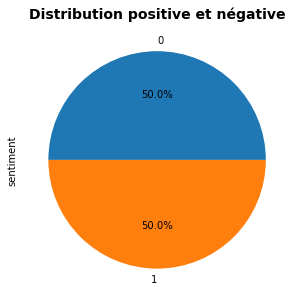

0    784689
1    784689
Name: sentiment, dtype: int64


In [34]:
# Trace la dictribution des tweets négatifs et positifs
plt.figure(figsize=(8, 5))

df['sentiment'].value_counts().plot(
    kind='pie',
    # Chiffre après la virgule
    autopct='%1.1f%%')
plt.title('Distribution positive et négative', fontsize=14, fontweight='bold')
plt.show()

print(df["sentiment"].value_counts())

# Visualisation

## Wordcloud

### Avec premier nettoyage

In [35]:
mot_negatif = df[df.sentiment == 0]
mot_positif = df[df.sentiment == 1]

In [36]:
def wordcloud(df, colonne):

    tous_tweet = str(df[colonne].values)
    tweet_negatif = str(mot_negatif[colonne].values)
    tweet_positif = str(mot_positif[colonne].values)

    # Instanciation de WordCloud
    wc_tous = WordCloud(width=600,
                        height=600,
                        background_color="white",
                        max_words=200,
                        max_font_size=90,
                        collocations=False,
                        random_state=42).generate(tous_tweet)

    wc_negatif = WordCloud(width=600,
                           height=600,
                           background_color="white",
                           max_words=200,
                           max_font_size=90,
                           collocations=False,
                           random_state=42).generate(tweet_negatif)

    wc_positif = WordCloud(width=600,
                           height=600,
                           background_color="white",
                           max_words=200,
                           max_font_size=90,
                           collocations=False,
                           random_state=42).generate(tweet_positif)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.imshow(wc_tous, interpolation='bilinear')
    ax1.set_title('Tous les tweets', fontsize=12, fontweight='bold')
    ax1.axis('off')

    ax2.imshow(wc_negatif, interpolation='bilinear')
    ax2.set_title('Tweets négatifs', fontsize=12, fontweight='bold')
    ax2.axis('off')

    ax3.imshow(wc_positif, interpolation='bilinear')
    ax3.set_title('Tweets positifs', fontsize=12, fontweight='bold')
    ax3.axis('off')

    plt.suptitle('Tweets Word Clouds', fontsize=16, fontweight='bold')
    plt.show()

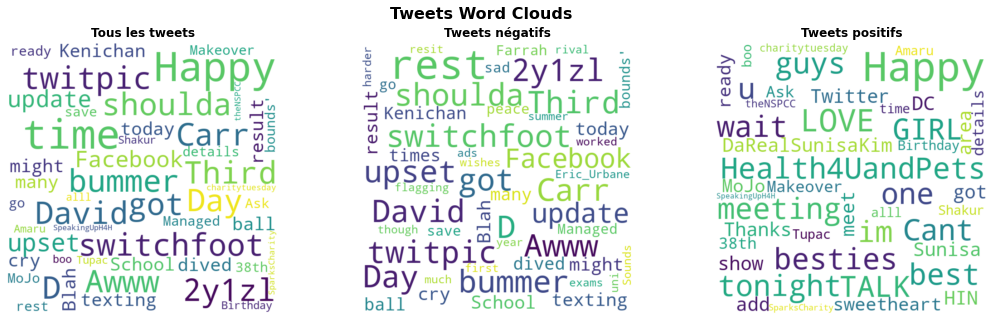

In [37]:
wordcloud(df, "tweet")

### Avec preprocessing

#### Tweet traite

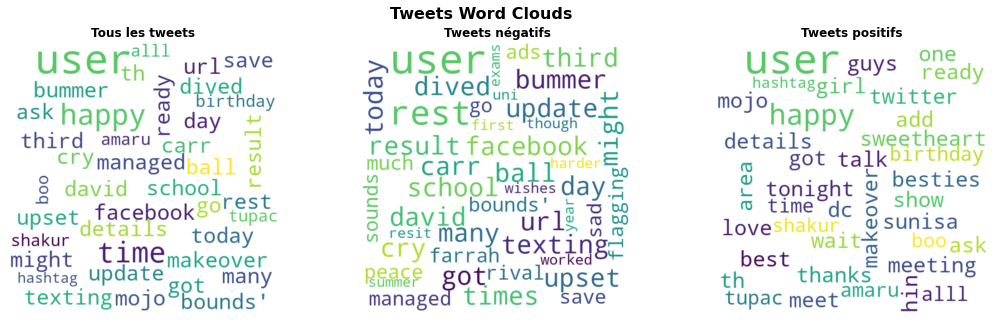

In [38]:
wordcloud(df, "tweet_traite")

#### Tweet lemm

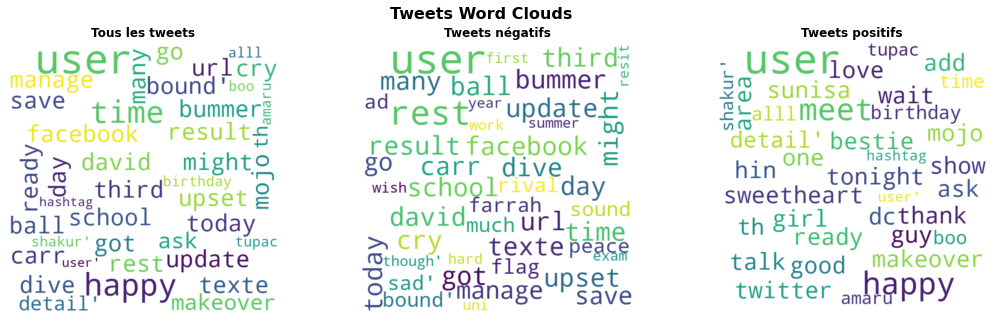

In [39]:
wordcloud(df, "tweet_lemm")

#### Tweet stemm

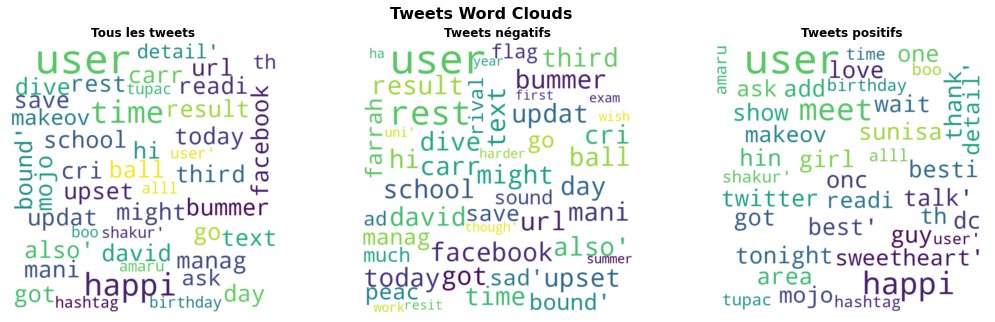

In [40]:
wordcloud(df, "tweet_stemm")

## Frequence

### Avec premier nettoyage

Nous allons maintenant regarder la fréquence de chaque mot pour les tweets avec le premier traitement, et avec les tweets traités avec, la lemmatisation, etc.

In [41]:
def frequence(df, colonne):
    # Créer une liste vide de chaînes de caractères
    mots = ''

    # Place chaque mot de chaque tweet dans la liste "mots"
    for i in df[colonne].values:
        mots += i
    print('Nombre de mots', len(mots))

    # 'mots.split()' split chaque mot de la chaine de caractère.
    # 'most_common(50)'' récupère les 50 mots les plus courants
    mots_frequence = pd.DataFrame(Counter(mots.split()).most_common(50),
                                  columns=['mot', 'frequence'])
    print(mots_frequence[:10])

    plt.figure(figsize=(18, 5))
    sns.barplot(x=mots_frequence.mot, y=mots_frequence.frequence)
    plt.xticks(rotation=45, ha='right')
    plt.title('Les mots les plus courants', fontsize=14, fontweight='bold')
    plt.show()

Nombre de mots 116705902
   mot  frequence
0   to     547509
1  the     481157
2    I     473725
3    a     360468
4   my     275321
5  and     272653
6    i     240641
7   is     208744
8  for     207534
9  you     206760


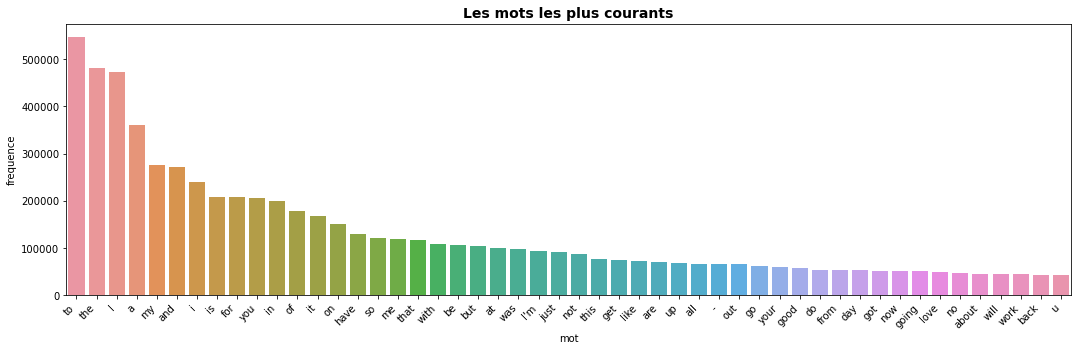

In [42]:
frequence(df, "tweet")

Nous pouvons voir que nous avons des mots très peu informatifs comme to, it, my, of, in etc. "I" a même plus de 900 000 occurrences.

Voyons du côté des tweets ayant subi le prépocessing.

### Avec preprocessing

#### Tweet traite

Nombre de mots 101130277
    mot  frequence
0  user     712367
1    to     612506
2   the     521938
3    is     428521
4   you     366418
5    it     345932
6    my     311822
7   and     300712
8   not     282187
9    am     240145


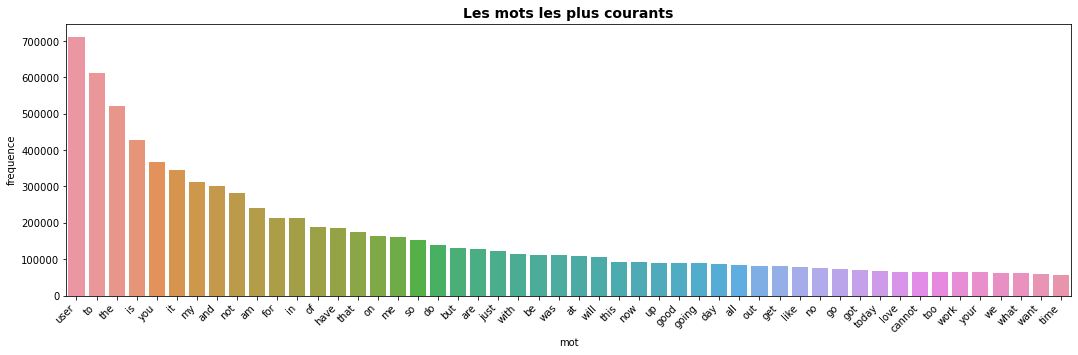

In [43]:
frequence(df, "tweet_traite")

#### Tweet lemm

Nombre de mots 96115888
    mot  frequence
0    be    1061410
1    to     610600
2   the     516833
3  user     363105
4   you     351961
5   not     343706
6    it     323399
7    my     299847
8   and     298792
9  have     272531


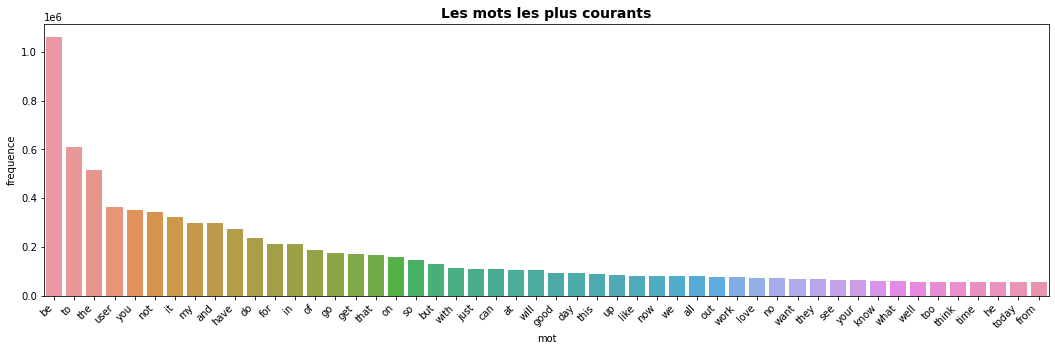

In [44]:
frequence(df, "tweet_lemm")

#### Tweet stemm

Nombre de mots 93502056
   mot  frequence
0   to     608653
1  the     512119
2   is     395198
3  you     339976
4   it     305087
5  and     296664
6   my     290337
7  not     274986
8   am     235993
9  for     211796


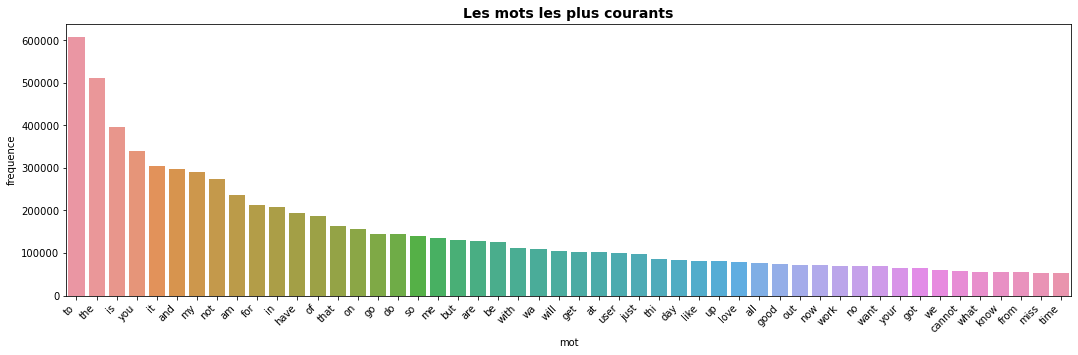

In [45]:
frequence(df, "tweet_stemm")

# Export de la dataframe

In [46]:
df.to_csv("data/df_preprocessing_final.csv", index=False)

# Conclusion

Nous avons maintenant nettoyer nos tweets, ils sont prêt pour notre prochain algorithme de machine learning.

Nous aurions pu amméliorer notre traitement sur plusieurs points :

- **Corrigé l'orthographe** :
    - Nous avons essayé deux librairie pour cela, **Textblob** et **Pyspellchecker**. Mais le traitement s'est vu être très très long, voir même faisait planter le notebook.
    
- **En traduisant les tweet non anglais**:
    - Nous avions peur de la qualité que pourrait avoir une traduction, et du coup, donner un faux sens à la phrase et fausser ensuite notre résultat.
    
- **En supprimant les noms et prénoms**:
    - Mais nous n'avons pas trouvé de résultat convacant, en générale, la librairie ne fait que supprimer les mots avec la première lettre en majuscule.
    
Le nettoyage de tweet a été fait à la main, mais il existe une librairie python qui permet de nettoyer des tweets automatiquement.